## overview
- pipeline that finds the best suggestion, prototype

In [288]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [289]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Data

In [290]:
df = pd.read_csv("data/filtered_model_data.csv")

In [291]:
df["start_time"] = df["start_time"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time"])

Create training data

In [292]:
# given a row of sessions, take domain_ids and domain_scores, which are in string format separated by ",", and replace with a list of the values
def process_row(row):
    values_a = [int(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [ ]:
# take in a dataframe of a patient's session, extract information useful for training
def create_training_data(data: pd.DataFrame):
    # Initialize variables
    session_row = [] # contents of a row (patient id, encoding, cur score, prev score, repeat)
    overall = [] # aggregate of everything (n sessions x 44)

    cur_score = np.zeros((14)) # score for each session
    cur_score.fill(np.nan)
    prev_score = None

    patient_id = data["patient_id"].iloc[0] # save patient_id

    # Sort data by session start time
    data = data.sort_values(by=["start_time"])

    # Process each row
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)  # returns a list of domains : int and of domain_scores : float

        for j, domain in enumerate(domains):
            cur_score[domain - 1] = domain_scores[j] # update score in the loop

        # Encode domains for this session
        domain_encoding = np.zeros(14)
        for domain in domains:
            domain_encoding[domain - 1] = 1
        

        # if the session does not contain the target domain or is the first (no prev score), continue in the loop without doing anything, do this before appending
        if prev_score is None:
            session_row = []
            prev_score = cur_score.copy()
            continue
        # assert np.sum(domain_encoding) != 1, "continue not working"

        # append everything in the row list
        session_row.append(patient_id)
        session_row.extend(domain_encoding.copy().tolist())
        session_row.extend(prev_score.copy().tolist())
        session_row.extend(cur_score.copy().tolist())
        session_row.append(row["start_time"].timestamp())
        assert len(session_row) == 44, "session row length incorrect"

        # append row to overall, reset
        overall.append(session_row)
        session_row = []
        prev_score = cur_score.copy()

    # Convert to numpy arrays
    if overall:
        overall = np.array(overall)
        assert len(overall.shape) == 2, "dimensions of overall wrong"
    else:
        # Handle case where scores is empty
        return pd.DataFrame(columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] +
                                   ["domain %d score" % i for i in range(1, 15)] +
                                   ["domain %d target" % i for i in range(1, 15)] +
                                   ["start_time"])
    
        # Create column names
    column_names = (
        ["patient_id"]
        + [f"domain {i} encoding" for i in range(1, 15)]
        + [f"domain {i} score" for i in range(1, 15)]
        + [f"domain {i} target" for i in range(1, 15)]
        + ["repeat"]
        + ["start_time"]
    )

    # Create dataframe
    scores_df = pd.DataFrame(overall, columns=column_names)
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [294]:
# data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

In [295]:
# data.to_csv("data/next_step_data.csv", index=False)

In [296]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

In [297]:
data = pd.read_csv("data/next_step_data.csv")

In [298]:
data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
0,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513443e+09
1,2171.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
2,2171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
3,2171.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
4,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835360,568669.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687208e+09
5835361,568669.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687210e+09
5835362,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687211e+09
5835363,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.218,0.827,NaN,1.0,1.687216e+09


In [299]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
n_samples = 100000

## one sample for train, only to see if it learns that one example
# train_data = train_data[:n_samples].copy()
test_data = test_data[:n_samples].copy()

In [301]:
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.000,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954103,228753.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,1.0,1.543280e+09
5421291,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.808,1.00,0.449,1.000,0.380,1.0,1.610984e+09
5137134,319140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.792,NaN,0.492,0.40,NaN,NaN,0.600,1.0,1.595794e+09
851176,80797.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.466,NaN,0.571,NaN,0.272,0.308,0.600,1.0,1.578844e+09


In [302]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [303]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    return data_scores, target

Model

In [304]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [305]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

In [306]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [307]:
# return predictions, loss, and mae
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [308]:
def overall_avg_improvement(cur_score, prev_score, encoding):
    cur_score = np.nan_to_num(cur_score, nan=0)
    prev_score = np.nan_to_num(prev_score, nan=0)
    assert cur_score.shape == prev_score.shape and prev_score.shape == encoding.shape
    if np.sum(encoding) == 0:
        total_improvement = 0
        print("no sessions")
    else:
        total = np.sum(encoding)
        total_improvement = np.sum(encoding * cur_score - encoding * prev_score) / total
    return total_improvement

In [309]:
def random_assignment(data):
    # sort by timestamp
    data = data.sort_values(by="start_time")
    # assign repeat values
    seen = dict() # Track repeat status and update scores
    repeat_lst = []
    for idx, row in data.iterrows():
            domain = row[encoding_columns].idxmax()
            if domain not in seen:
                seen[domain] = 1
                repeat_lst.append(0)
            else:
                repeat_lst.append(1)
    data.drop(repeat_columns[0], axis=1, inplace=True)
    data[repeat_columns[0]] = repeat_lst    
    return data

Calculate Ground Truth

### prepare data

In [310]:
ground_truth_test_data_repeat = test_data[test_data.repeat == 1].copy()
ground_truth_test_data_nonrepeat = test_data[test_data.repeat == 0].copy()

In [311]:
ground_truth_test_data_n_zeros_repeat = dict() ## a dictionary that stores the data on the key of the number of missing domains
for n in range(14):
    tmp = filter_n_missing(ground_truth_test_data_repeat, n_missing=n)
    ground_truth_test_data_n_zeros_repeat[n] = tmp.copy()

In [312]:
ground_truth_test_data_n_zeros_nonrepeat = dict() ## a dictionary that stores the data on the key of the number of missing domains
for n in range(14):
    tmp = filter_n_missing(ground_truth_test_data_nonrepeat, n_missing=n)
    ground_truth_test_data_n_zeros_nonrepeat[n] = tmp.copy()

In [313]:
np.isnan(ground_truth_test_data_n_zeros_repeat[1][score_columns]).sum().sum(), ground_truth_test_data_n_zeros_repeat[1].shape[0]

(210, 210)

### plot preparations

In [314]:
ground_truth_prediction_dict_repeat = dict() # dictionary that stores the prediction list
ground_truth_avg_improvement_lst_repeat = []

In [315]:
# loop through number of domains
for n in range(14):
    print(n)
    tmp = ground_truth_test_data_n_zeros_repeat[n] # set tmp to the data used for this iteration
    assert np.isnan(tmp[score_columns]).sum().sum() == tmp.shape[0] * n
    x_tmp, y_tmp = create_model_data(tmp) # create scores with missing indicators and target

    encoding = tmp[encoding_columns].copy().to_numpy() # encoding
    tmp_single = add_encoding(x_tmp, encoding) # add encoding on x_tmp
    prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    
    ground_truth_prediction_dict_repeat[n] = prediction
    ground_truth_avg_improvement_lst_repeat.append(overall_avg_improvement(tmp[target_columns].to_numpy(), ground_truth_test_data_n_zeros_repeat[n][score_columns].to_numpy(), encoding))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
no sessions


In [320]:
summ = 0
for n in range(14):
    summ += ground_truth_test_data_n_zeros_repeat[n].shape[0]

summ

997

In [323]:
ground_truth_test_data_repeat

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.000,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954103,228753.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,1.0,1.543280e+09
5421291,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.808,1.00,0.449,1.000,0.380,1.0,1.610984e+09
5137134,319140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.792,NaN,0.492,0.40,NaN,NaN,0.600,1.0,1.595794e+09
851176,80797.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.466,NaN,0.571,NaN,0.272,0.308,0.600,1.0,1.578844e+09


In [316]:
ground_truth_avg_improvement_lst_repeat[13]

0

In [328]:
scores = ground_truth_test_data_repeat[score_columns]
# Count number of nans in each row
missing_count = scores.isna().sum(axis=1)

# Filter rows with n_zeros number of zeros
filtered_rows = ground_truth_test_data_repeat[missing_count > 12]

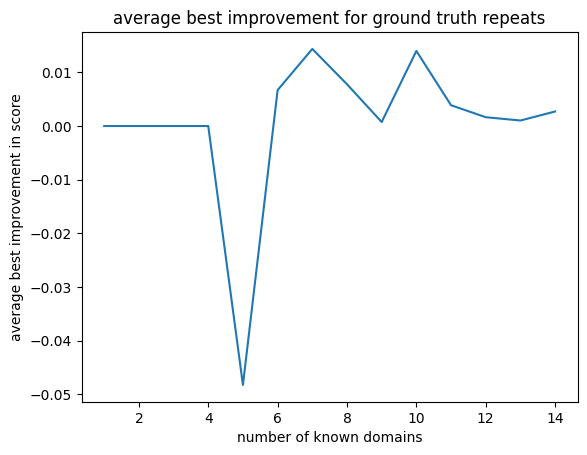

In [317]:
plt.figure()
plt.plot(range(1,15), ground_truth_avg_improvement_lst_repeat[::-1])
plt.xlabel("number of known domains")
plt.ylabel("average best improvement in score")
plt.title("average best improvement for ground truth repeats")
plt.show()

In [147]:
ground_truth_prediction_dict_nonrepeat = dict() # dictionary that stores the prediction list
ground_truth_avg_improvement_lst_nonrepeat = []

In [ ]:
# loop through number of domains
for n in range(14):
    print(n)
    tmp = ground_truth_test_data_n_zeros_nonrepeat[n] # set tmp to the data used for this iteration
    x_tmp, y_tmp = create_model_data(tmp) # create scores with missing indicators and target

    encoding = tmp[encoding_columns].copy().to_numpy() # encoding
    tmp_single = add_encoding(x_tmp, encoding) # add encoding on x_tmp
    prediction, loss, mae = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    
    ground_truth_prediction_dict_nonrepeat[n] = prediction
    ground_truth_avg_improvement_lst_nonrepeat.append(overall_avg_improvement(tmp[target_columns].to_numpy(), ground_truth_test_data_n_zeros_nonrepeat[n][score_columns].to_numpy(), encoding))

no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions


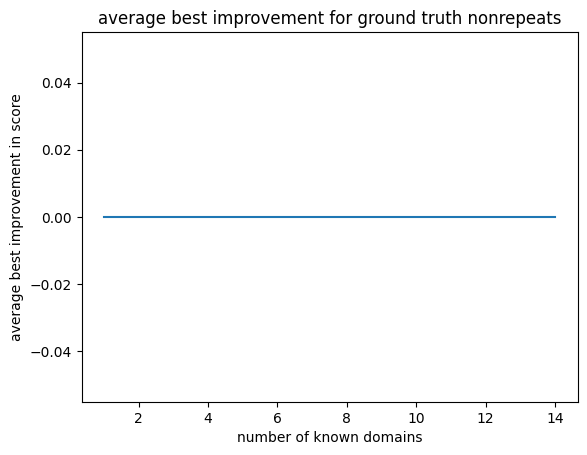

In [149]:
plt.figure()
plt.plot(range(1,15), ground_truth_avg_improvement_lst_nonrepeat[::-1])
plt.xlabel("number of known domains")
plt.ylabel("average best improvement in score")
plt.title("average best improvement for ground truth nonrepeats")
plt.show()
## TODO: double check that this matches the average

overall stats

In [150]:
overall_avg_improvement(ground_truth_test_data_repeat[target_columns].to_numpy(), ground_truth_test_data_repeat[score_columns].to_numpy(), ground_truth_test_data_repeat[encoding_columns].to_numpy())

0.0055

In [151]:
overall_avg_improvement(ground_truth_test_data_nonrepeat[target_columns].to_numpy(), ground_truth_test_data_nonrepeat[score_columns].to_numpy(), ground_truth_test_data_nonrepeat[encoding_columns].to_numpy())

no sessions


0

Predict Random

In [152]:
# take in a dataframe of a patient's session, extract information useful for training
def create_random_data(data: pd.DataFrame):
    # Initialize variables
    session_row = [] # contents of a row (patient id, encoding, cur score, prev score, repeat)
    overall = [] # aggregate of everything (n sessions x 44)

    cur_score = np.zeros((14)) # score for each session
    cur_score.fill(np.nan)
    prev_score = None

    # seen = {} # dictionary for seen
    patient_id = data["patient_id"].iloc[0] # save patient_id

    # Sort data by session start time
    data = data.sort_values(by=["start_time"])

    # Process each row
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)  # returns a list of domains : int and of domain_scores : float
        domain = np.random.choice(14, 1)[0] # choose a random domain instead

        # Track repeat status and update scores
        if prev_score is None:
            repeat = False
        else:
            # find if domain already has a score
            next_domain_score = prev_score[domain]
            if np.isnan(next_domain_score): repeat = False
            else: repeat = True
        # repeat = False

        # for j, domain in enumerate(domains):
        # if domain not in seen:
        #     seen[domain] = True
        # else:
        #     repeat = True
        
        for j, domain in enumerate(domains):
            cur_score[domain - 1] = domain_scores[j] # update score in the loop

        # Encode domains for this session
        domain_encoding = np.zeros(14)
        domain_encoding[domain - 1] = 1
        
        

        # if the session does not contain the target domain or is the first (no prev score), continue in the loop without doing anything, do this before appending
        if prev_score is None:
            session_row = []
            prev_score = cur_score.copy()
            continue
        # assert np.sum(domain_encoding) != 1, "continue not working"

        # append everything in the row list
        session_row.append(patient_id)
        session_row.extend(domain_encoding.copy().tolist()) #encoding
        session_row.extend(prev_score.copy().tolist()) # score
        session_row.extend(cur_score.copy().tolist())# target
        session_row.append(repeat)
        session_row.append(row["start_time"].timestamp())
        assert len(session_row) == 45, "session row length incorrect"

        # append row to overall, reset
        overall.append(session_row)
        session_row = []
        prev_score = cur_score.copy()

    # Convert to numpy arrays
    if overall:
        overall = np.array(overall)
        assert len(overall.shape) == 2, "dimensions of overall wrong"
    else:
        # Handle case where scores is empty
        return pd.DataFrame(columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] +
                                   ["domain %d score" % i for i in range(1, 15)] +
                                   ["domain %d target" % i for i in range(1, 15)] +
                                   ["repeat"] +
                                   ["start_time"])
    
        # Create column names
    column_names = (
        ["patient_id"]
        + [f"domain {i} encoding" for i in range(1, 15)]
        + [f"domain {i} score" for i in range(1, 15)]
        + [f"domain {i} target" for i in range(1, 15)]
        + ["repeat"]
        + ["start_time"]
    )

    # Create dataframe
    scores_df = pd.DataFrame(overall, columns=column_names)
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [153]:
def create_random_encoding(shape):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Get matrix dimensions
    rows, cols = shape
    # Create a zero matrix
    encoding = np.zeros((rows, cols), dtype=int)
    # Generate a random column index for each row
    col_indices = np.random.randint(0, cols, size=rows)  # Shape (100000,)
    # Assign 1s at the randomly selected column indices
    encoding[np.arange(rows), col_indices] = 1
    return encoding

In [154]:
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions, loss, mae = predict(model, x_random, torch.from_numpy(y).float())
    return predictions, e

In [155]:
def random_repeat_assignment(data):
    # replace encoding
    encoding = create_random_encoding(data[encoding_columns].shape)
    data[encoding_columns] = encoding
    # assign repeat
    data = data.groupby("patient_id")[data.columns].apply(random_assignment).reset_index(drop=True)
    return data

In [156]:
temp = test_data.copy()
temp = temp[temp.patient_id == 2171.0].head()
temp

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time


In [157]:
encoding = create_random_encoding(temp[encoding_columns].shape)

In [158]:
temp[encoding_columns]

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding


In [159]:
temp[encoding_columns] = encoding

In [160]:
encoding

array([], shape=(0, 14), dtype=int64)

In [161]:
temp[encoding_columns]

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding


In [162]:
random_test_data = df.groupby("patient_id")[df.columns].apply(create_random_data).reset_index(drop=True)

In [163]:
random_test_data_repeat = random_test_data[random_test_data.repeat == 1].copy()
random_test_data_nonrepeat = random_test_data[random_test_data.repeat == 0].copy()

In [164]:
random_x_test_repeat, random_y_test_repeat = create_model_data(random_test_data_repeat)
random_x_test_nonrepeat, random_y_test_nonrepeat = create_model_data(random_test_data_nonrepeat)

In [165]:
random_test_data_n_zeros_repeat = dict() ## a dictionary that stores the data on the key of the number of missing domains
for n in range(14):
    tmp = filter_n_missing(random_test_data_repeat, n_missing=n)
    random_test_data_n_zeros_repeat[n] = tmp.copy()

In [166]:
random_prediction_dict_repeat = dict() # dictionary that stores the prediction list
random_avg_improvement_lst_repeat = []

In [168]:
# loop through number of domains
for n in range(14):
    tmp = random_test_data_n_zeros_repeat[n] # set tmp to the data used for this iteration

    encoding = tmp[encoding_columns]
    prediction, encoding = find_random_predictions(tmp)
    
    random_prediction_dict_repeat[n] = prediction
    random_avg_improvement_lst_repeat.append(overall_avg_improvement(prediction, random_test_data_n_zeros_repeat[n][score_columns].to_numpy(), encoding))

In [169]:
random_prediction_repeat, random_encoding_repeat = find_random_predictions(random_test_data_repeat)
overall_avg_improvement(random_prediction_repeat, random_test_data_repeat[score_columns].to_numpy(), random_encoding_repeat)

-0.004004904584843019

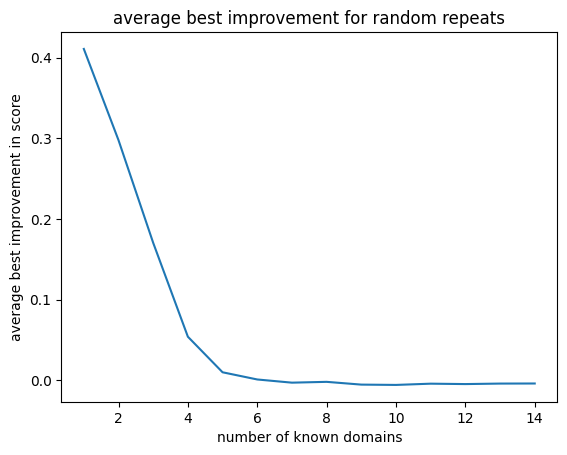

In [170]:
plt.figure()
plt.plot(range(1,15), random_avg_improvement_lst_repeat[::-1])
plt.xlabel("number of known domains")
plt.ylabel("average best improvement in score")
plt.title("average best improvement for random repeats")
plt.show()

In [171]:
random_prediction_dict_nonrepeat = dict() # dictionary that stores the prediction list
random_avg_improvement_lst_nonrepeat = []

In [172]:
random_test_data_n_zeros_nonrepeat = dict() ## a dictionary that stores the data on the key of the number of missing domains
for n in range(14):
    tmp = filter_n_missing(random_test_data_nonrepeat, n_missing=n)
    random_test_data_n_zeros_nonrepeat[n] = tmp.copy()

In [173]:
# loop through number of domains
for n in range(14):
    tmp = random_test_data_n_zeros_nonrepeat[n] # set tmp to the data used for this iteration

    prediction, encoding = find_random_predictions(tmp)
    
    random_prediction_dict_nonrepeat[n] = prediction
    random_avg_improvement_lst_nonrepeat.append(overall_avg_improvement(prediction, random_test_data_n_zeros_nonrepeat[n][score_columns].to_numpy(), encoding))

no sessions


In [174]:
random_prediction_nonrepeat, random_encoding_nonrepeat = find_random_predictions(random_test_data_nonrepeat)
overall_avg_improvement(random_prediction_nonrepeat, random_test_data_nonrepeat[score_columns].to_numpy(), random_encoding_nonrepeat)

0.000908459656946316

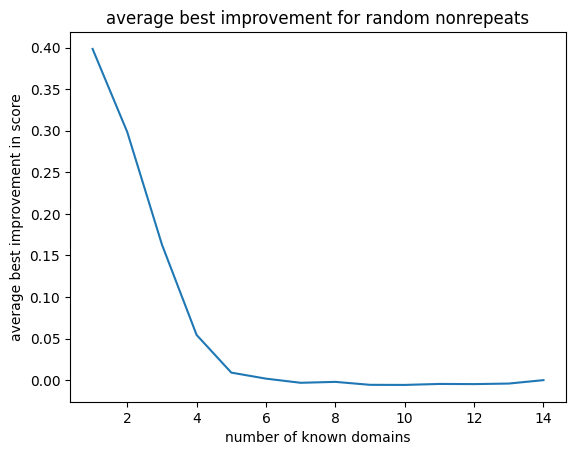

In [175]:
plt.figure()
plt.plot(range(1,15), random_avg_improvement_lst_nonrepeat[::-1])
plt.xlabel("number of known domains")
plt.ylabel("average best improvement in score")
plt.title("average best improvement for random nonrepeats")
plt.show()

Predict Best

In [176]:
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [177]:
def predict_all_domains(x, y):
    prediction_list = []
    rows, cols = y.shape
    # loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
    for domain in range(14):
        encoding = create_single_encoding(rows, cols, domain)
        x_single = add_encoding(x, encoding)
        single_prediction, loss, mae = predict(model, x_single, torch.from_numpy(y).float())
        prediction_list.append(single_prediction[:, domain])
    return prediction_list

In [178]:
def find_best_idx_pred(x, y, original):
    prediction_lst = predict_all_domains(x, y)
    prediction_matrix = np.column_stack(prediction_lst)  # Shape: (100000, 14)
    difference = prediction_matrix - original
    # Find the index of the max difference for each row
    max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
    rows, cols = y.shape
    # Create a zero matrix of shape (100000, 14)
    encoding = np.zeros((rows, cols), dtype=int)
    # Assign 1s at the max_indices positions to create the full encoding matrix with best domains
    encoding[np.arange(rows), max_indices] = 1
    # create a zero matrix of shape (100000, 14)
    predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
    # Fill in the max values at their corresponding positions
    predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
    return encoding, predictions

In [179]:
def best_repeat_assignment(data_dict, encoding_dict, pred_dict):
    # replace encoding
    for key, val in data_dict.items():
         val[encoding_columns] = encoding_dict[key]
         val[target_columns] = pred_dict[key]
    # combine data
    combined_data = pd.concat(data_dict.values(), ignore_index=True)
    # assign repeat
    combined_data = combined_data.groupby("patient_id")[combined_data.columns].apply(random_assignment).reset_index(drop=True)
    return combined_data

In [180]:
best_test_data = test_data.copy()

In [181]:
best_prediction_dict = dict() # dictionary that stores the prediction lists, key = number of domains missing
best_encoding_dict = dict() # dictionary that stores the best encoding, key = number of domains missing

In [182]:
best_test_data_n_zeros = dict() ## a dictionary that stores the data on the key of the number of missing domains
for n in range(14):
    tmp = filter_n_missing(best_test_data, n_missing=n)
    best_test_data_n_zeros[n] = tmp.copy()

In [183]:
# loop through number of domains, add a list of predictions (len == 14) to best_prediction_dict
for n in range(14):
    tmp = best_test_data_n_zeros[n] # set tmp to the data used for this iteration
    x_tmp, y_tmp = create_model_data(tmp) # create scores with missing indicators and target
    rows, cols = y_tmp.shape
    prediction_list = []
    # loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
    for domain in range(14):
        encoding = create_single_encoding(rows, cols, domain)
        tmp_single = add_encoding(x_tmp, encoding)
        single_prediction, loss, mae = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
        prediction_list.append(single_prediction[:, domain])
    
    best_prediction_dict[n] = prediction_list

In [184]:
# loop through number of domains, for each set (data with n domains missing), find the best encoding and best predictions
for n in range(14):
    prediction_matrix = np.column_stack(best_prediction_dict[n])  # Shape: (100000, 14)
    difference = prediction_matrix - best_test_data_n_zeros[n][score_columns].to_numpy()
    rows, cols = prediction_matrix.shape
    # Find the index of the max difference for each row
    max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
    # Create a zero matrix of shape (100000, 14)
    best_encoding = np.zeros((rows, cols), dtype=int)
    # Assign 1s at the max_indices positions to create the full encoding matrix with best domains
    best_encoding[np.arange(rows), max_indices] = 1
    best_encoding_dict[n] = best_encoding
    # create a zero matrix of shape (100000, 14)
    best_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
    # Fill in the max values at their corresponding positions
    best_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
    best_prediction_dict[n] = best_predictions

In [185]:
best_data = best_repeat_assignment(best_test_data_n_zeros, best_encoding_dict, best_prediction_dict)

In [186]:
best_avg_improvement_lst_repeat = []
best_avg_improvement_lst_nonrepeat = []

In [187]:
for n in range(14):
    tmp = filter_n_missing(best_data, n_missing=n)
    tmp_repeat = tmp[tmp.repeat == 1].copy()
    tmp_nonrepeat = tmp[tmp.repeat == 0].copy()
    best_avg_improvement_lst_repeat.append(overall_avg_improvement(tmp_repeat[target_columns].to_numpy(), tmp_repeat[score_columns].to_numpy(), tmp_repeat[encoding_columns].to_numpy()))
    best_avg_improvement_lst_nonrepeat.append(overall_avg_improvement(tmp_nonrepeat[target_columns].to_numpy(), tmp_nonrepeat[score_columns].to_numpy(), tmp_nonrepeat[encoding_columns].to_numpy()))

no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions
no sessions


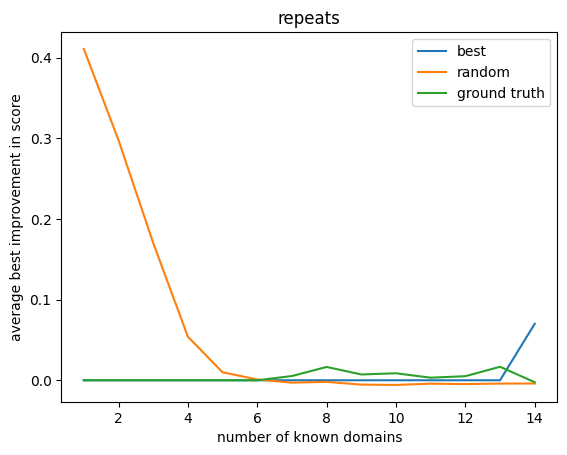

In [188]:
plt.figure()
plt.plot(range(1,15), best_avg_improvement_lst_repeat[::-1], label="best")
plt.plot(range(1,15), random_avg_improvement_lst_repeat[::-1], label="random")
plt.plot(range(1,15), ground_truth_avg_improvement_lst_repeat[::-1], label="ground truth")
plt.xlabel("number of known domains")
plt.ylabel("average best improvement in score")
plt.title("repeats")
plt.legend()
plt.show()

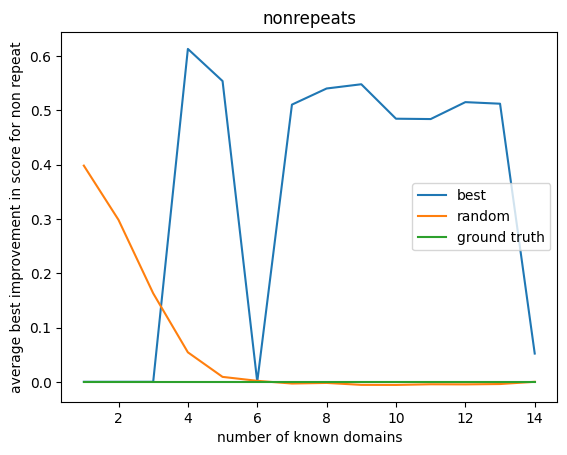

In [189]:
plt.figure()
plt.plot(range(1,15), best_avg_improvement_lst_nonrepeat[::-1], label="best")
plt.plot(range(1,15), random_avg_improvement_lst_nonrepeat[::-1], label="random")
plt.plot(range(1,15), ground_truth_avg_improvement_lst_nonrepeat[::-1], label="ground truth")
plt.xlabel("number of known domains")
plt.ylabel("average best improvement in score for non repeat")
plt.title("nonrepeats")
plt.legend()
plt.show()

debugging stuff

In [190]:
tmp = filter_n_missing(best_data, n_missing=13)
tmp_nonrepeat = tmp[tmp.repeat == 0].copy()

In [191]:
tmp = filter_n_missing(best_test_data, n_missing=1)
tmp_nonrepeat = tmp[tmp.repeat == 0].copy()

In [192]:
domain = tmp_nonrepeat[encoding_columns].idxmax(axis=1)
missing_score = tmp_nonrepeat.columns[tmp_nonrepeat.isna().any()]

In [193]:
tmp1 = filter_n_missing(best_data, n_missing=13)
tmp_nonrepeat = tmp1[tmp1.repeat == 1].copy()
x_tmp1, y_tmp1 = create_model_data(tmp_nonrepeat) # create scores with missing indicators and target

encoding1 = tmp_nonrepeat[encoding_columns].copy().to_numpy() # encoding
tmp_single1 = add_encoding(x_tmp1, encoding1) # add encoding on x_tmp
prediction1, loss, mae = predict(model, tmp_single1, torch.from_numpy(y_tmp1).float())

In [194]:
tmp = ground_truth_test_data_n_zeros_nonrepeat[13] # set tmp to the data used for this iteration
x_tmp, y_tmp = create_model_data(tmp) # create scores with missing indicators and target

encoding = tmp[encoding_columns].copy().to_numpy() # encoding
tmp_single = add_encoding(x_tmp, encoding) # add encoding on x_tmp
prediction, loss, mae = predict(model, tmp_single, torch.from_numpy(y_tmp).float())

In [195]:
for n in range(14):
    tmp = filter_n_missing(best_data, n_missing=n)
    tmp_repeat = tmp[tmp.repeat == 1].copy()
    tmp_nonrepeat = tmp[tmp.repeat == 0].copy()
    total_sessions = tmp_repeat.shape[0]
    print("# of missing = %d, # of sessions = %d" % (n, total_sessions))
    print(np.isnan(tmp_repeat[score_columns]).sum(axis=1).sum() + np.isnan(tmp_nonrepeat[score_columns]).sum(axis=1).sum() == n * total_sessions)

# of missing = 0, # of sessions = 3
True
# of missing = 1, # of sessions = 0
False
# of missing = 2, # of sessions = 0
False
# of missing = 3, # of sessions = 0
False
# of missing = 4, # of sessions = 0
False
# of missing = 5, # of sessions = 0
False
# of missing = 6, # of sessions = 0
False
# of missing = 7, # of sessions = 0
False
# of missing = 8, # of sessions = 0
True
# of missing = 9, # of sessions = 0
False
# of missing = 10, # of sessions = 0
False
# of missing = 11, # of sessions = 0
True
# of missing = 12, # of sessions = 0
True
# of missing = 13, # of sessions = 0
True


In [196]:
tmp1.shape

(0, 45)

In [197]:
tmp_nonrepeat[score_columns].head()

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score


In [198]:
tmp_nonrepeat[encoding_columns].head()

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding


In [199]:
tmp.shape

(0, 45)

In [200]:
for n in range(14):
    tmp = filter_n_missing(best_data, n_missing=n)
    tmp_repeat = tmp[tmp.repeat == 1].copy()
    tmp_nonrepeat = tmp[tmp.repeat == 0].copy()
    total_sessions = tmp_repeat.shape[0] + tmp_nonrepeat.shape[0]
    print("# of missing = %d, # of sessions = %d" % (n, total_sessions))
    print(np.isnan(tmp_repeat[score_columns]).sum(axis=1).sum() + np.isnan(tmp_nonrepeat[score_columns]).sum(axis=1).sum() == n * total_sessions)

# of missing = 0, # of sessions = 33
True
# of missing = 1, # of sessions = 22
True
# of missing = 2, # of sessions = 15
True
# of missing = 3, # of sessions = 7
True
# of missing = 4, # of sessions = 11
True
# of missing = 5, # of sessions = 4
True
# of missing = 6, # of sessions = 2
True
# of missing = 7, # of sessions = 3
True
# of missing = 8, # of sessions = 0
True
# of missing = 9, # of sessions = 2
True
# of missing = 10, # of sessions = 1
True
# of missing = 11, # of sessions = 0
True
# of missing = 12, # of sessions = 0
True
# of missing = 13, # of sessions = 0
True


In [201]:
for n in range(14):
    total_sessions = ground_truth_test_data_n_zeros_nonrepeat[n].shape[0] + ground_truth_test_data_n_zeros_repeat[n].shape[0]
    print("# of missing = %d, # of sessions = %d" % (n, total_sessions))
    print(np.isnan(ground_truth_test_data_n_zeros_nonrepeat[n][score_columns]).sum(axis=1).sum() + np.isnan(ground_truth_test_data_n_zeros_repeat[n][score_columns]).sum(axis=1).sum() == n * total_sessions)

# of missing = 0, # of sessions = 33
True
# of missing = 1, # of sessions = 22
True
# of missing = 2, # of sessions = 15
True
# of missing = 3, # of sessions = 7
True
# of missing = 4, # of sessions = 11
True
# of missing = 5, # of sessions = 4
True
# of missing = 6, # of sessions = 2
True
# of missing = 7, # of sessions = 3
True
# of missing = 8, # of sessions = 0
True
# of missing = 9, # of sessions = 2
True
# of missing = 10, # of sessions = 1
True
# of missing = 11, # of sessions = 0
True
# of missing = 12, # of sessions = 0
True
# of missing = 13, # of sessions = 0
True
